# Proccessing, analysis, and visualization pipeline for event-related multi-unit-activity electrophysiology data
## The goal of this pipeline is to create group-level peri-event binned histograms for data from 2 groups (experimental and control), then extract the average spike rate during the event timing for straightforward comparisons of group-level event-related activity
## Designed for data batch pre-processed in Neuroexplorer using the "Striatum-Batch-MUA_PSD_LFP.py" script to apply the "FirstPulses.ntp", "LFPSPEC_Final.ntp", "LFPTIMEPSD_Final.ntp", and "MUAPEH2.ntp" templates to raw data 

In [ ]:
%pylab inline
%load_ext autoreload
%autoreload 2
import pynit as pn #to handle BIDS-style data organization
import os
import pandas as pd
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import numpy as np
from pandas import DataFrame, date_range, datetime, read_csv
from matplotlib import pyplot, colors, rcParams 
from datetime import timedelta
from numpy import NaN, asarray
from math import isnan
import seaborn as sns

rcParams['figure.dpi'] = 300
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Liberation Sans']

import warnings
warnings.filterwarnings("ignore")

# Plotting helper function

In [2]:
def tsplot(df, add_plot=None, figsize=None, xlim=None, ylim=None, xlabel=None, ylabel=None,
               label_size=None, tick_size=None, title=None, title_size=None, err=0, **kwargs):
        """

        :param df:
        :param figsize:
        :param xlim:
        :param ylim:
        :param xlabel:
        :param ylabel:
        :param label_size:
        :param tick_size:
        :param title:
        :param title_size:
        :param err: 0 = standard deviation, 1 = standard error
        :param kwargs:
        :return:
        """
        if not add_plot:
            fig, axes = plt.subplots(1,1,figsize=figsize)
        else:
            fig, axes = add_plot
        fig.patch.set_facecolor('white')
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        for axis in ['top','bottom','left','right']:
              axes.spines[axis].set_linewidth(5)
        if xlim:
            axes.set_xlim(xlim)
        if ylim:
            axes.set_ylim(ylim)
        if title:
            axes.set_title(title, size=title_size)
        if xlabel:
            axes.set_xlabel(xlabel, size=label_size)
        else:
            axes.set_xlabel('Time (s)', size=label_size)
        if ylabel:
            axes.set_ylabel(ylabel, size=label_size)
        else:
            axes.set_ylabel('Responses', size=label_size)

        tlen = int(tick_size/5)
        
        axes.tick_params(labelsize=tick_size, direction='out', top='off', right='off', width = 5, length = tlen)
        grey2 = [colors.to_rgba('grey',.1)]
        
        if err == 1:
            sns.tsplot(df.T.values, err_style='sterr_band', ax=axes,  **kwargs)

        elif err == 0:
            sns.tsplot(df.T.values, err_style=None, ax=axes, **kwargs)
        else:
            sns.tsplot(df.T.values, err_style='unit_traces', err_palette = grey2, err_kws = {'alpha':.15}, ax=axes, **kwargs)
        return fig, axes

# load BIDS format project object from parent directory
## This should point to project in a \project\subproject\group\dtype\ directory organization

In [ ]:
prj = pn.Project('/project-folder-path') # load project object
prj.reload() # reload all updates
prj(2, ext=['.xlsx']).summary

# function to get group-level data from project object

In [3]:
def get_data(prj, group, cond):
    new_prj = prj(2, 'subproject-folder-name', group, cond, ext='.xlsx') #enter your subproject folder here
    df = pd.DataFrame()
    for f, finfo in new_prj:
        try:
            dff = pd.read_excel(finfo.Abspath, index_col = None).dropna()
            df = pd.concat([df, dff], axis=1, ignore_index=True)
        except:
            pass
    return df

# Plotting function for peri-event MUA timeseries data for 2 conditions (e.g. experimental and control), data is z-normalized, plotted and extracted to excel, then average firing frequency during the event period is extracted for each trial from each group

## set experimental parameters here or when calling the function

In [4]:
def plot_data(prj, group, first_cond = 'ChR2', second_cond = 'eYFP', blength = 99, figsize=[7.5,7.5], figsizeb=[12.5,7.5], label_size=60, err=1, title_size=60,
              tick_size=50, ylabel='Z-Score', xlabel='Time (s)', n_tick_b=100, stim=[[100],100], n_tick_a = 1, ylim = [-1,5],
              linewidth = 5):
    
    sstart = stim[0][0]
    send = stim[1]+stim[0][0]
    
    try:
        data_HbT = get_data(prj, group, first_cond)
    except:
        data_G = get_data(prj, group, second_cond)
        data_HbT = data_G * np.nan
    try:
        data_G = get_data(prj, group, second_cond)
    except:
        data_G = data_HbT * np.nan    
        
    for col in data_HbT.columns:
        data_HbT[col]= ((data_HbT[col] - np.mean(data_HbT[col].iloc[0:blength]))/np.std(data_HbT[col].iloc[0:blength]))
    
    for col in data_G.columns:
        data_G[col]= ((data_G[col] - np.mean(data_G[col].iloc[0:blength]))/np.std(data_G[col].iloc[0:blength]))
        
   
    ax = tsplot(data_G, color = 'tab:grey', err=err, figsize=figsize,label_size=label_size, title_size=title_size,
                         tick_size=tick_size, ylabel= 'Spikes / 100 ms (Z)', xlabel=xlabel, ylim=ylim, linewidth=linewidth)
    ax = tsplot(data_HbT, color = 'tab:red', err=err, figsize=figsize,label_size=label_size, title_size=title_size,
                         tick_size=tick_size, ylabel= 'Spikes / 100 ms (Z)', xlabel=xlabel, ylim=ylim, linewidth=linewidth, add_plot = ax)
    
    ax[1].set_xlim(right = data_HbT.shape[0])
    ax[1].yaxis.set_major_locator(ticker.MultipleLocator(n_tick_a))
    ax[1].xaxis.set_major_locator(ticker.MultipleLocator(n_tick_b))
    ax[1].xaxis.set_major_formatter(FuncFormatter(numfmt))

    ylim_neg = ax[1].get_ylim()
    if stim:
        for p in stim[0]:
            ax[1].add_patch(patches.Rectangle((p, ylim_neg[0]), stim[1], abs(ylim_neg[0])+abs(ylim_neg[1]),color='g', alpha=0.09))

    data_HbT.to_excel('{}_{}.xlsx'.format(group, first_cond), index = None, header = None)
    data_G.to_excel('{}_{}.xlsx'.format(group, second_cond), index = None, header = None)     
            
            
    ap = data_G.plot(cmap='summer',legend=False, figsize=figsize, linewidth=linewidth/4)
    ap.set_prop_cycle(pyplot.rcParams["axes.prop_cycle"])
    Gdf = DataFrame()

    Gcsvdf = DataFrame(data=None, columns=['Name','StimAVG', 'StimX'])

    styles = {}
    count=0
    for name in data_G.columns:
        list = data_G[name].tolist();

        stimavg = np.mean(list[sstart:send])

        stimx= sstart+((send-sstart)/2)

        newcol = []
        newcol = newcol + [NaN]*(data_G.count()[0]);

        newcol[stimx] = stimavg

        Gdf[int(name)] = newcol

        Gcsvdf = Gcsvdf.append({'Name':name, 'StimAVG': stimavg, 'StimX':stimx}, ignore_index=True);

    Gcsvdf.to_csv('{}_{}_{}.csv'.format(group, second_cond, 'MUAStimAVG'))

    a = Gdf.plot(marker= 7, color='black', legend=False, ax = ap)
#     ylim_neg = ax[1].get_ylim(
    ylim_neg = ap.get_ylim()

    if stim:
        for p in stim[0]:
            ap.add_patch(patches.Rectangle((p, ylim_neg[0]), stim[1], abs(ylim_neg[0])+abs(ylim_neg[1]),color='b', alpha=0.09))


    pyplot.show()

    
    ap1 = data_HbT.plot(cmap='summer',legend=False, figsize=figsize, linewidth=linewidth/4)
    ap.set_prop_cycle(pyplot.rcParams["axes.prop_cycle"])
    Gdf1 = DataFrame()
    
    Gcsvdf1 = DataFrame(data=None, columns=['Name','StimAVG', 'StimX'])
    
    styles = {}
    count=0
    for name in data_HbT.columns:
        list = data_HbT[name].tolist();
        
        stimavg = np.mean(list[sstart:send])

        stimx= sstart+((send-sstart)/2)
        
        newcol = []
        newcol = newcol + [NaN]*(data_HbT.count()[0]);
        
        newcol[stimx] = stimavg

        Gdf1[int(name)] = newcol

        Gcsvdf1 = Gcsvdf1.append({'Name':name, 'StimAVG': stimavg, 'StimX':stimx}, ignore_index=True);
   
    Gcsvdf1.to_csv('{}_{}_{}.csv'.format(group, first_cond, 'MUAStimAVG'))
      
    a1 = Gdf1.plot(marker= 7, color='black', legend=False, ax = ap1)

    ylim_negb = ap1.get_ylim()

    if stim:
        for p in stim[0]:
            ap.add_patch(patches.Rectangle((p, ylim_negb[0]), stim[1], abs(ylim_negb[0])+abs(ylim_negb[1]),color='b', alpha=0.09))

         
  
    pyplot.show()
    
    return ax, ap, ap1

## Optional function to convert x axis time series values

In [5]:
def numfmt(x, pos): # custom formatter function
    s = '{:.0f}'.format((x -100) / 10)
    return s

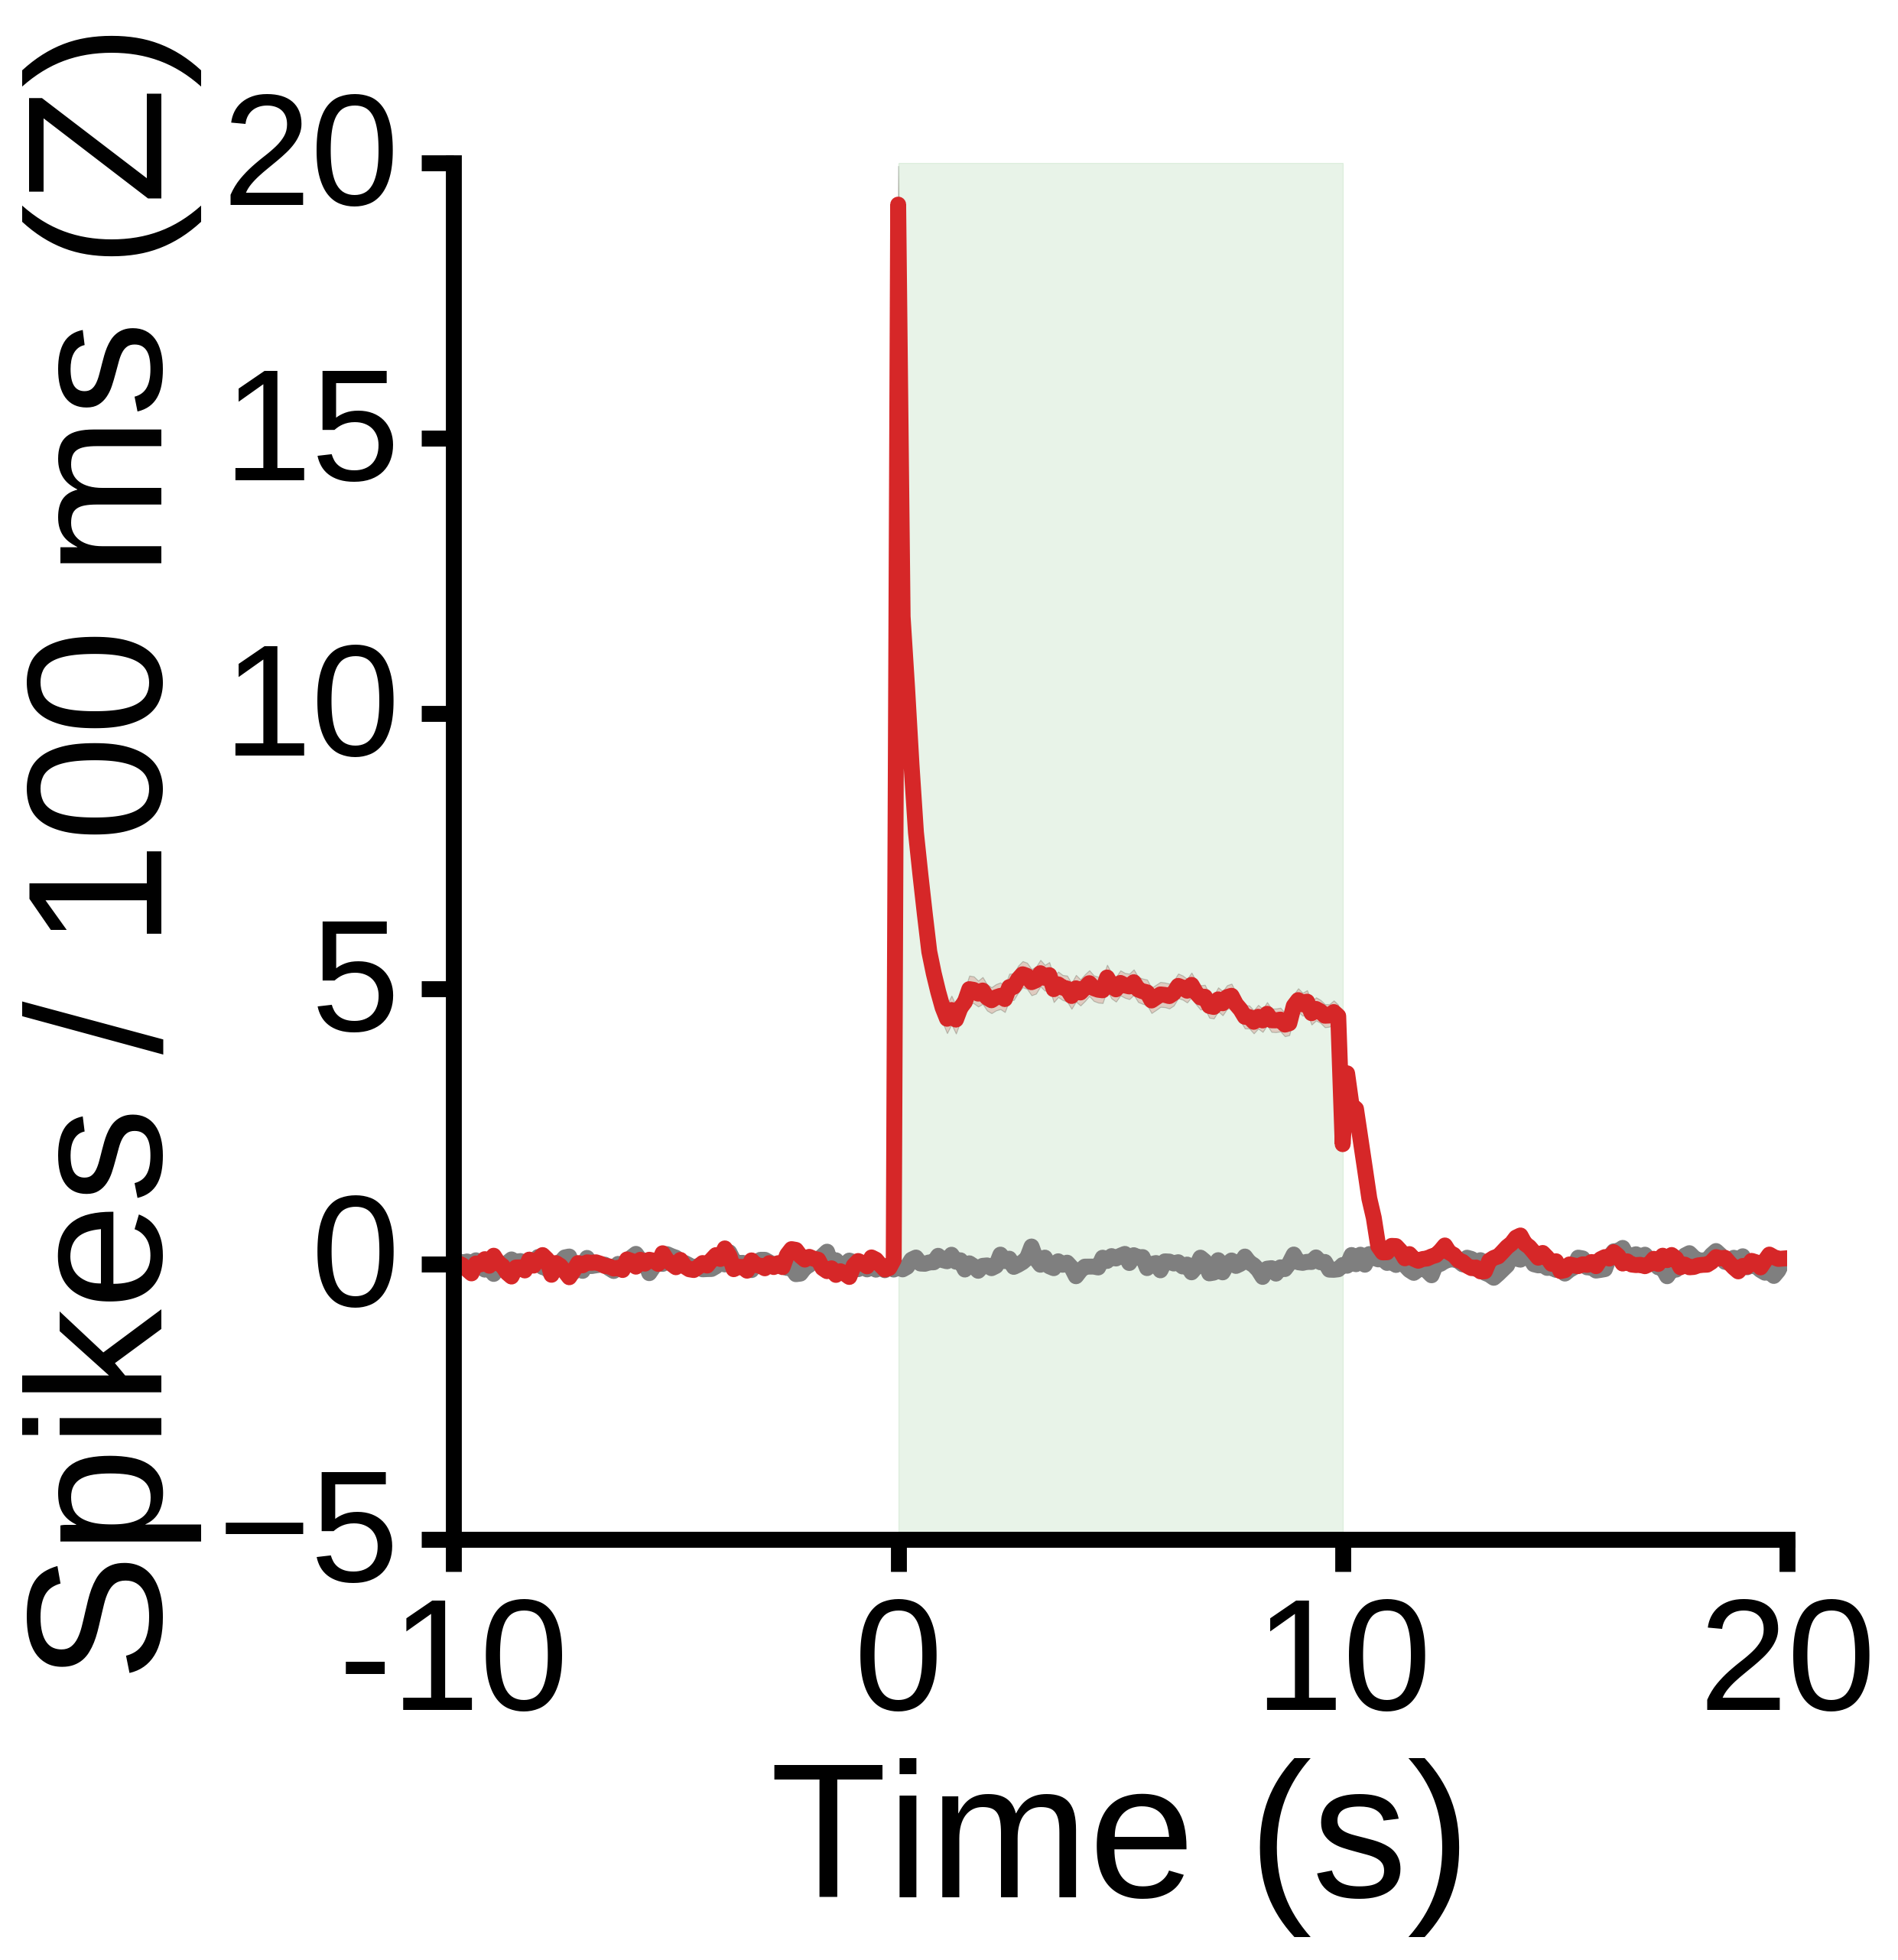

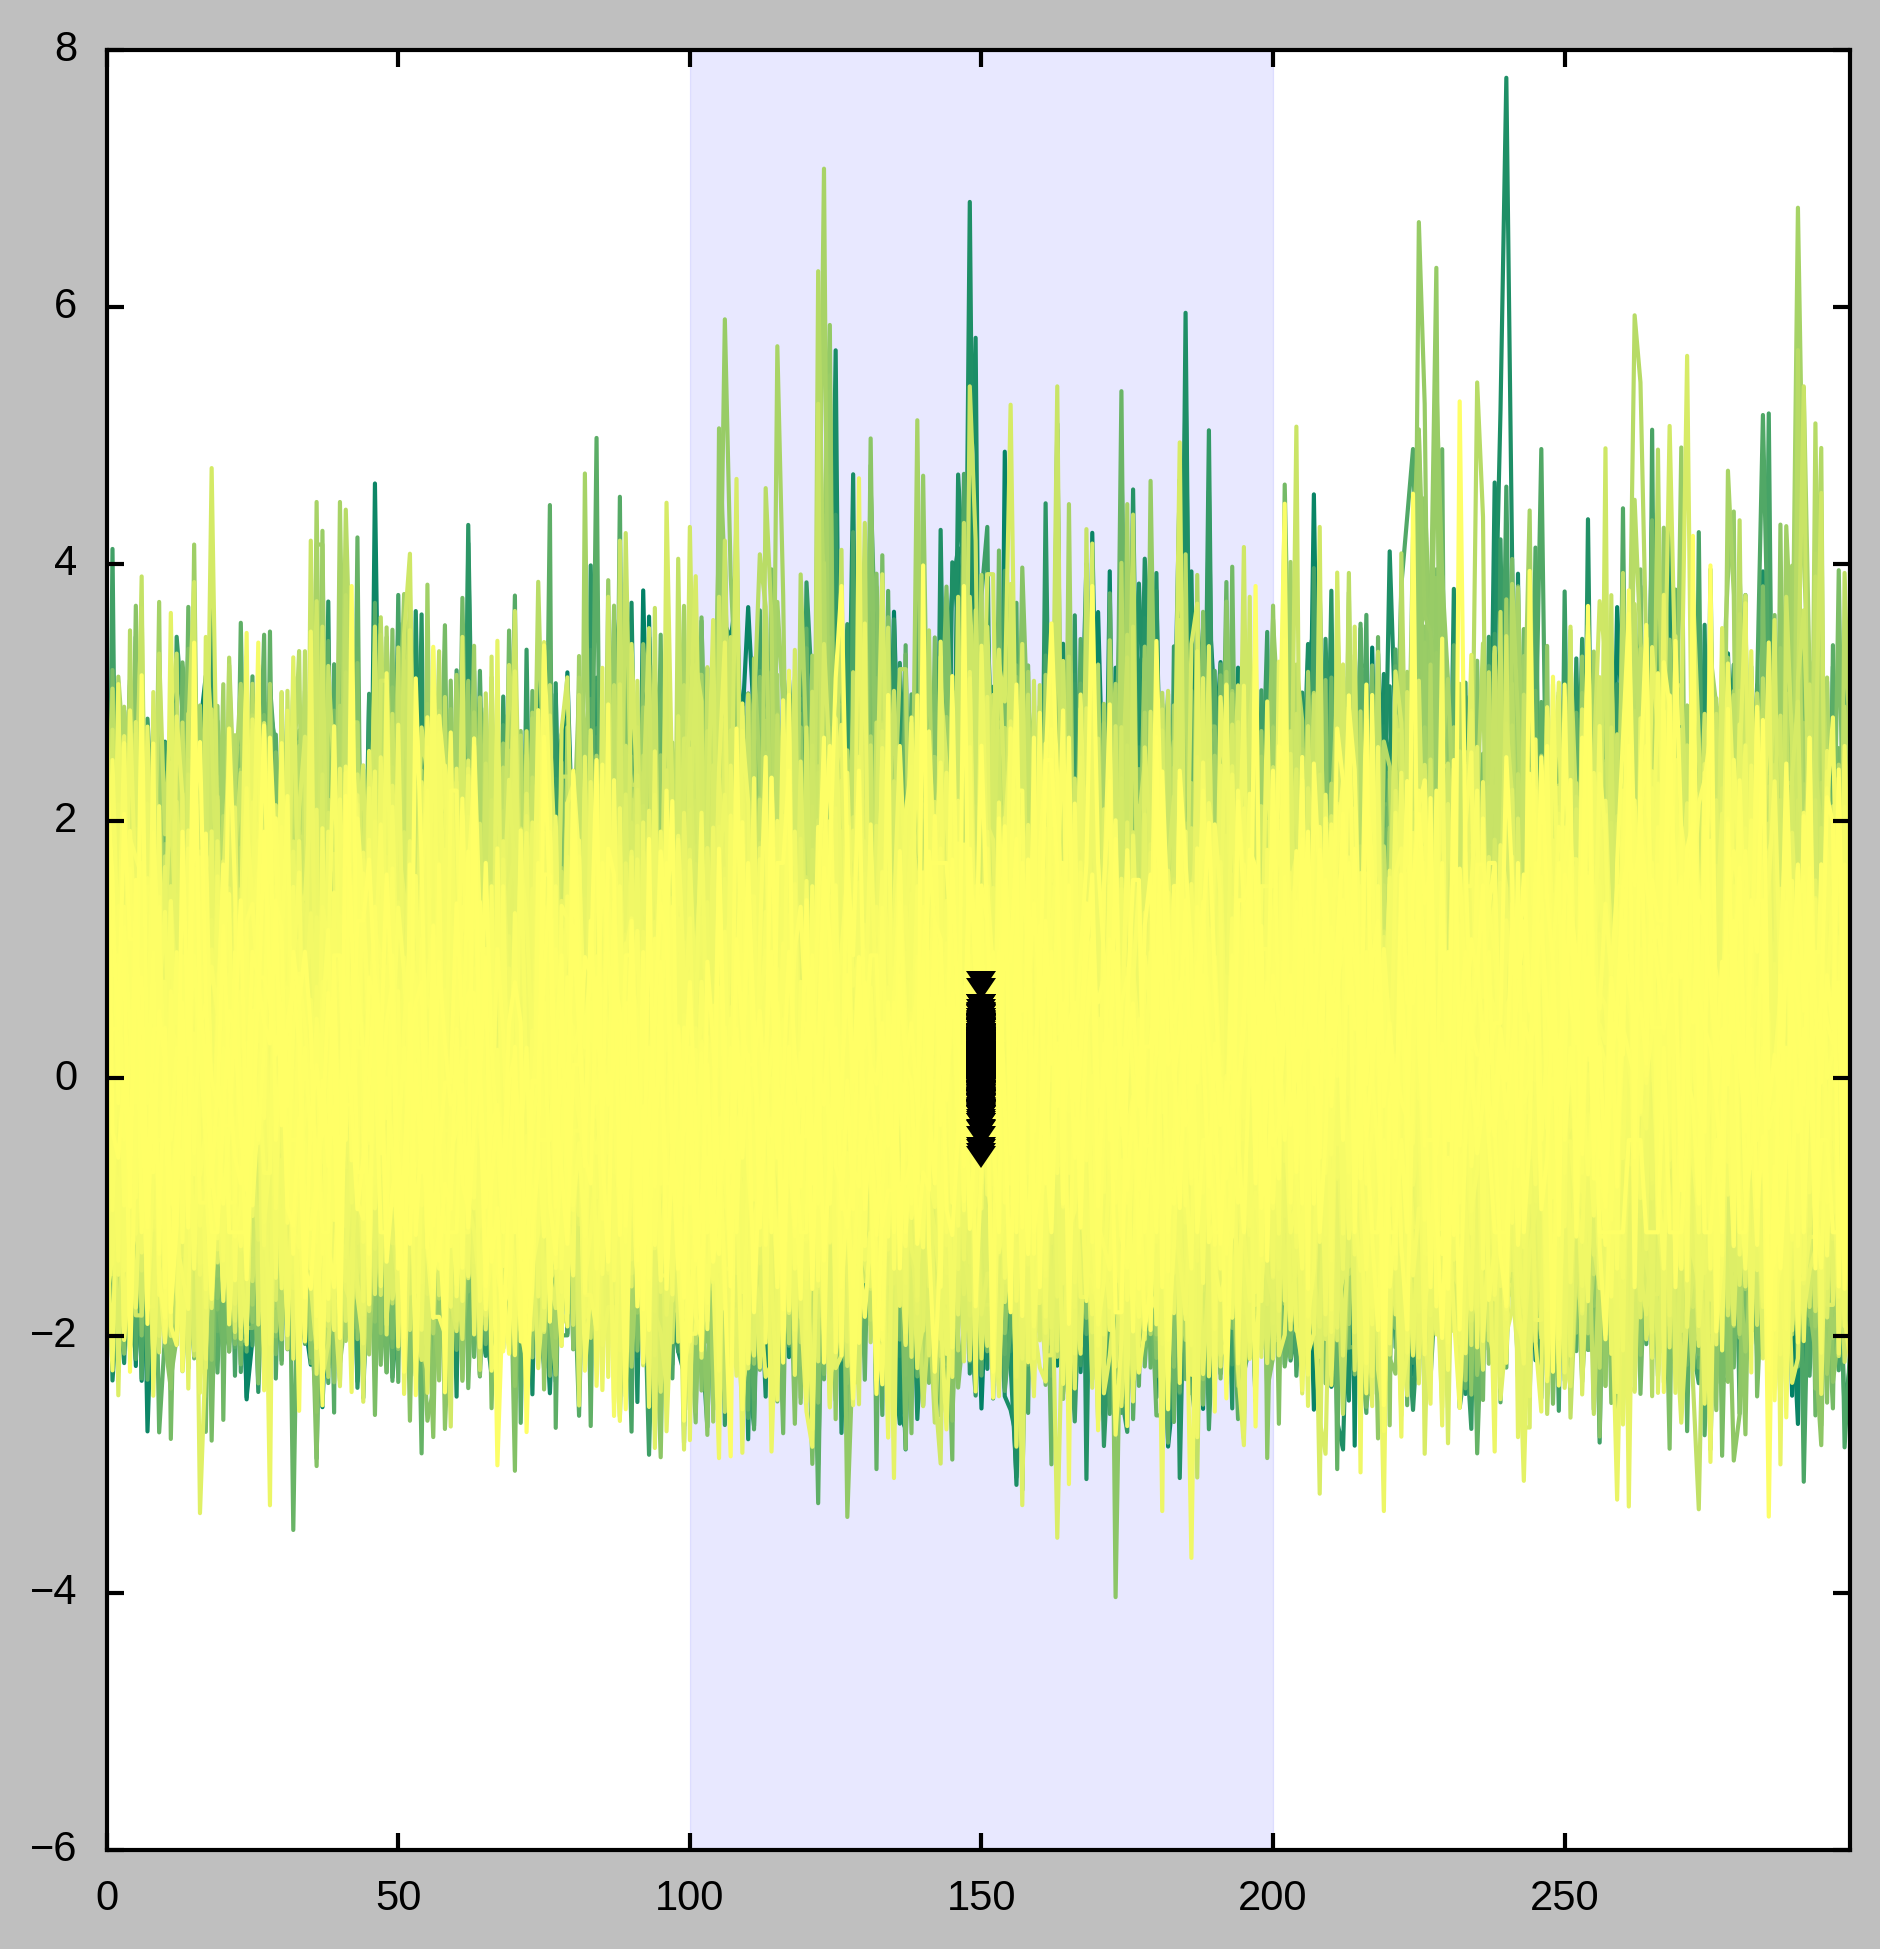

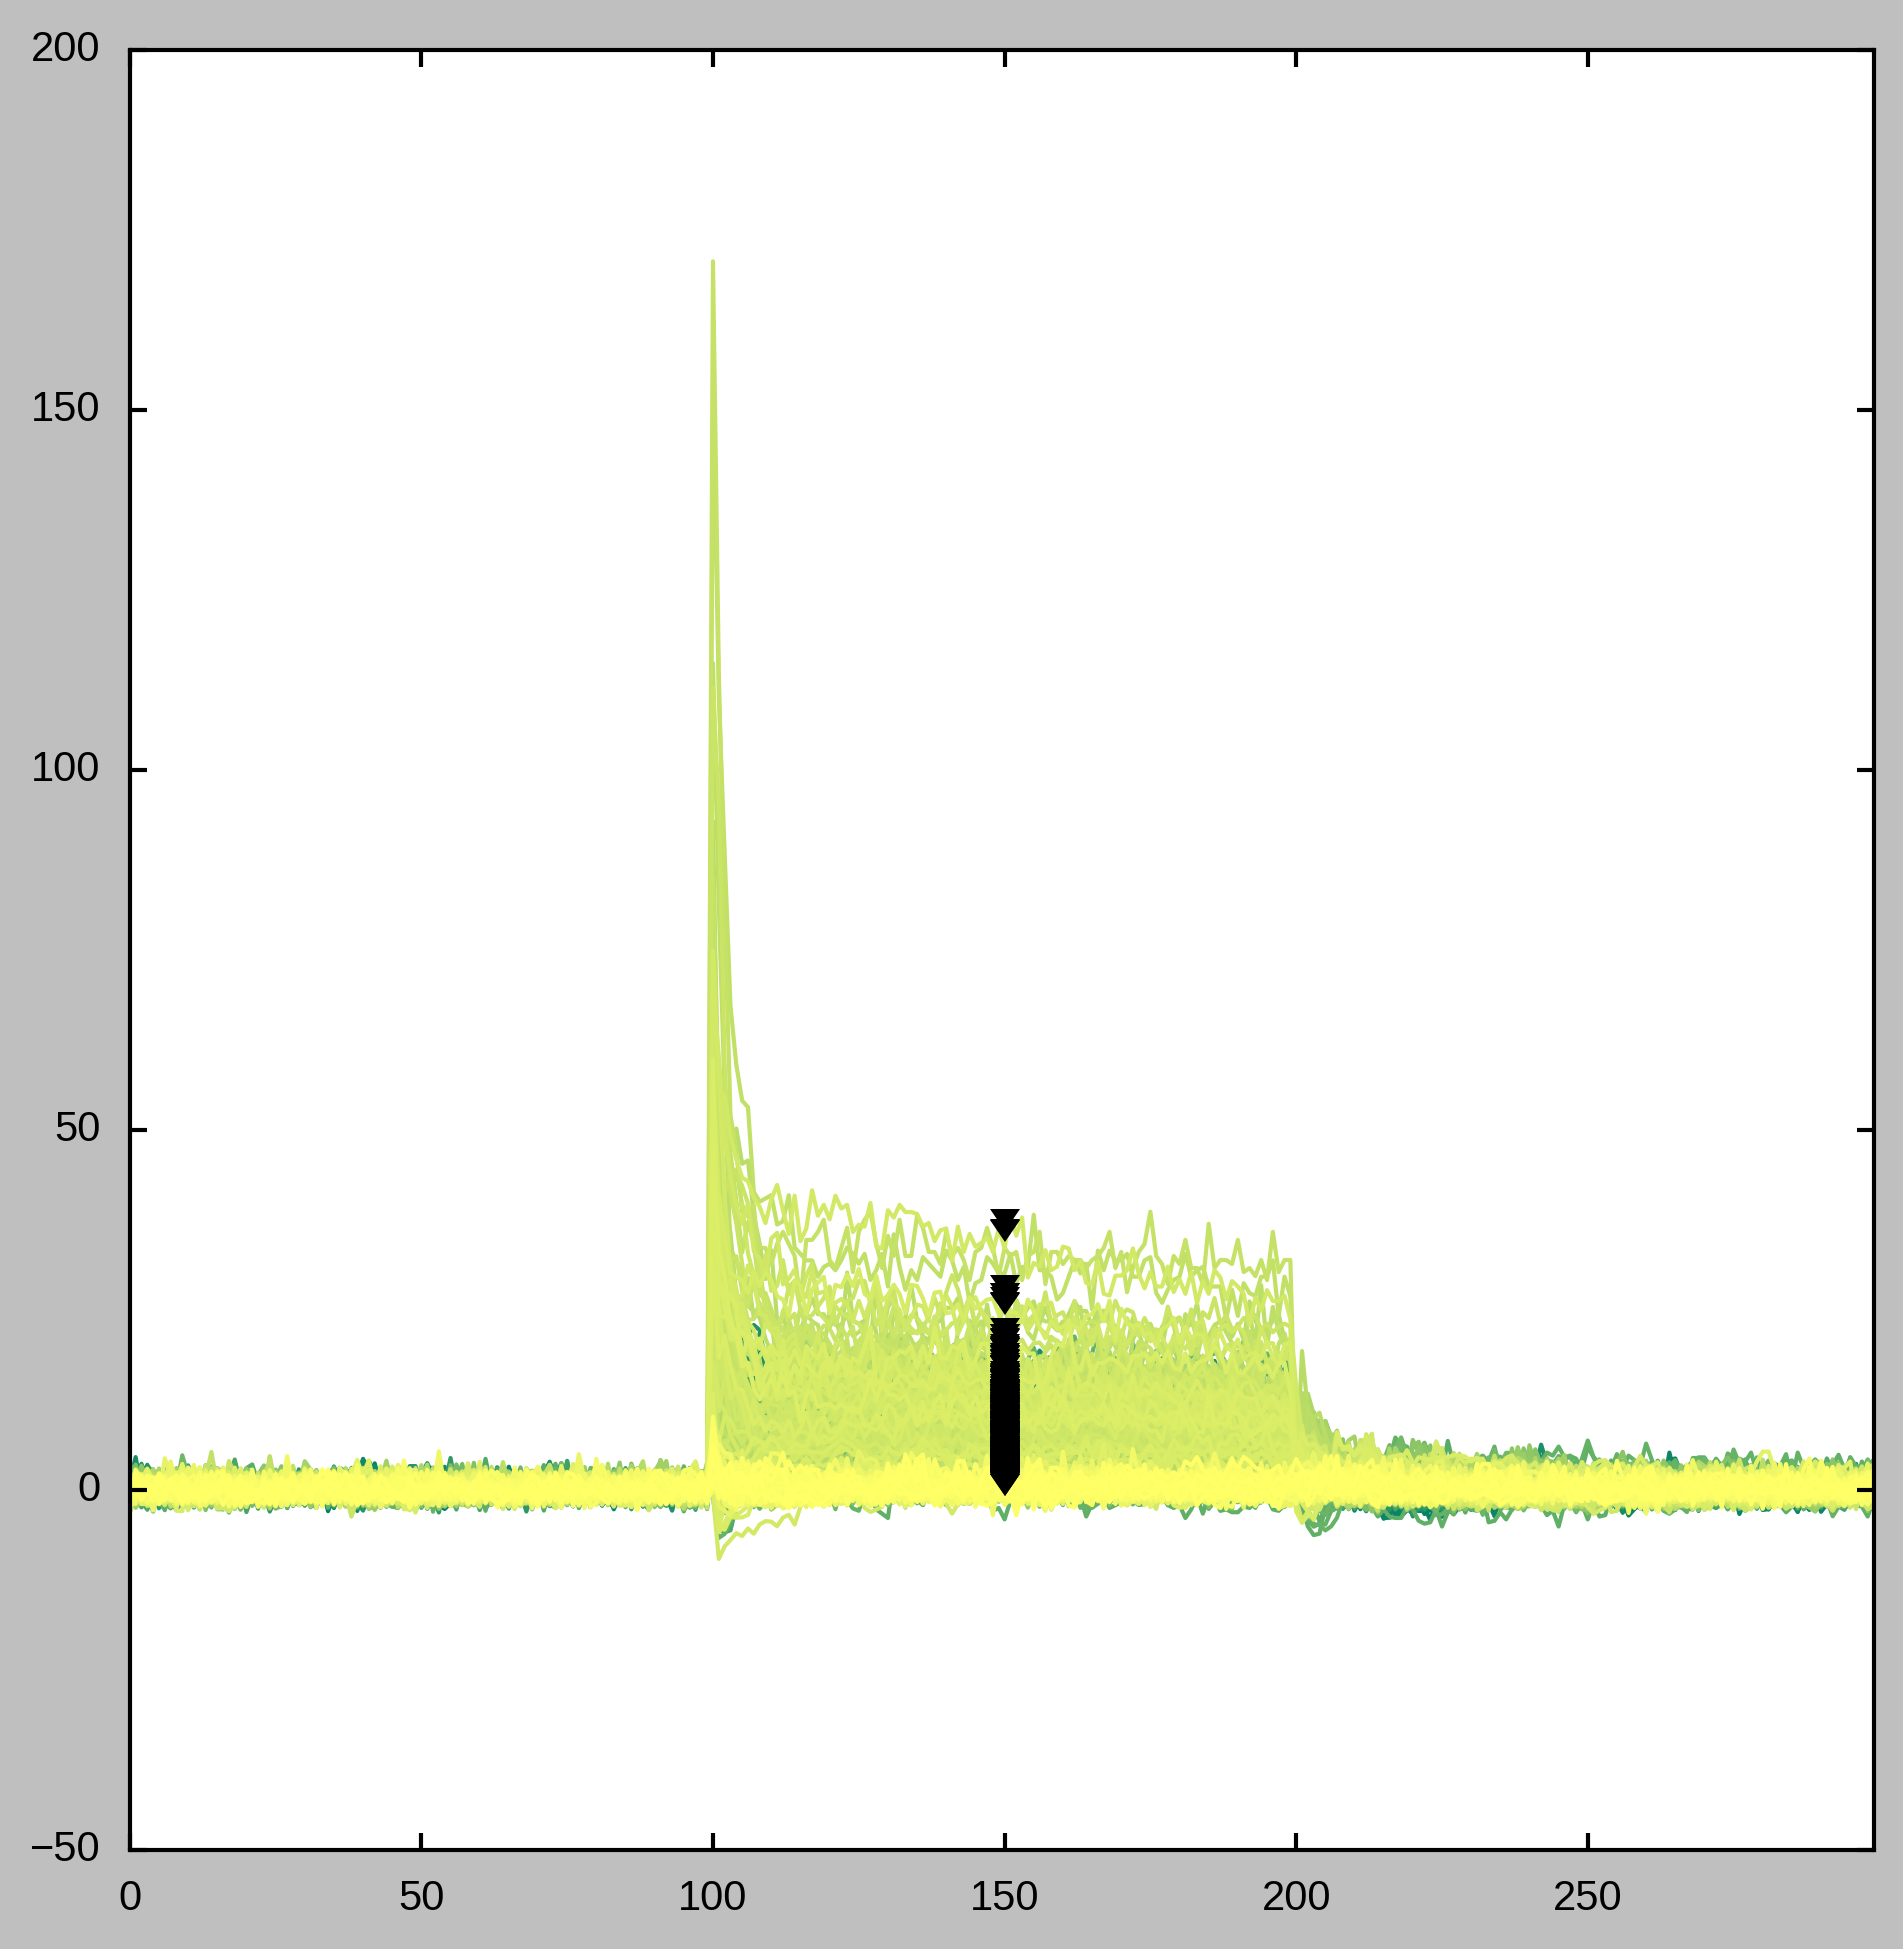

((<matplotlib.figure.Figure at 0x7f2860a08310>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f27ff2e1190>),
 <matplotlib.axes._subplots.AxesSubplot at 0x7f27fec82f90>)

In [8]:
plot_data(prj, 'group-folder-name',ylim = [-5,20],n_tick_a = 5)